In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import scipy.stats as stats
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import pickle
import csv
import statistics

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import timeit

In [4]:
rlist = []
records = os.path.normpath('mit-bih-dataframes/subject_list.csv')
with open(records) as rfile:
    recordreader = csv.reader(rfile, delimiter=' ', quotechar='|')
    for row in recordreader:
        rlist.append(row[0])

In [5]:
feature_dfs = {}
for record in tqdm(rlist):
    feature_dfs[record] = pd.read_csv(os.path.normpath('mit-bih-time-features/'+record+'.csv'), index_col=0, dtype={'subjectID': str})

100%|███████████████████████████████████████████| 23/23 [00:01<00:00, 22.85it/s]


In [6]:
statallfeatures_dict = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [7]:
start_time = timeit.default_timer()

logreg = LogisticRegression(solver='liblinear')

acc_score = []
Truth = []
Output = []

for idx, record in enumerate(feature_dfs):
    test_df = feature_dfs[record][1:]
    train_df = pd.concat([value[1:] for key, value in feature_dfs.items() if key != record])

    X_train = train_df[['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'std', 'cov', 'range', 'rrInt_var', 'rmean_var', 'rmssd', 'mad', 'iqr']]
    y_train = train_df['mappedLabel']

    X_test = test_df[['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'std', 'cov', 'range', 'rrInt_var', 'rmean_var', 'rmssd', 'mad', 'iqr']]
    y_test = test_df['mappedLabel']

    logreg.fit(X_train, y_train)
    pred_values = logreg.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dict['Run Time'].append(elapsed)
statallfeatures_dict['Accuracy'].append(np.mean(acc_score))
statallfeatures_dict['Standard Error'].append(np.std(acc_score))
statallfeatures_dict['Sensitivity'].append(sensitivity)
statallfeatures_dict['Specificity'].append(specificity)
statallfeatures_dict['Precision'].append(precision)
statallfeatures_dict['F1_Score'].append(f1_score)

---Run time is 135.563692653 seconds ---

Accuracy of each fold: 
 [0.9134654818865345, 0.9411707601203767, 0.9942684766214178, 0.9125491297024144, 0.9850521291295063, 0.9421897810218978, 0.8871329298363596, 0.968570960877394, 0.9146473779385171, 0.8505747126436781, 0.9756842220041435, 0.9682045965094177, 0.813834422657952, 0.9161814281336194, 0.5567082294264339, 0.9732180964575331, 0.9847707333222976, 0.8763358778625954, 0.538430338673697, 0.947938689217759, 0.9932591155142477, 0.9385382059800664, 0.9964667878053705]
Avg accuracy: 0.9038779340584014
Std of accuracy : 
0.1195380284634706
confusion matrix: 
[[76225  8447]
 [10999 91886]]
classification report: 
              precision    recall  f1-score   support

        Afib       0.87      0.90      0.89     84672
    Non-Afib       0.92      0.89      0.90    102885

    accuracy                           0.90    187557
   macro avg       0.89      0.90      0.90    187557
weighted avg       0.90      0.90      0.90    187557

0.90

In [8]:
start_time = timeit.default_timer()

lda = LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

for idx, record in enumerate(feature_dfs):
    test_df = feature_dfs[record][1:]
    train_df = pd.concat([value[1:] for key, value in feature_dfs.items() if key != record])

    X_train = train_df[['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'std', 'cov', 'range', 'rrInt_var', 'rmean_var', 'rmssd', 'mad', 'iqr']]
    y_train = train_df['mappedLabel']

    X_test = test_df[['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'std', 'cov', 'range', 'rrInt_var', 'rmean_var', 'rmssd', 'mad', 'iqr']]
    y_test = test_df['mappedLabel']

    lda.fit(X_train, y_train)
    pred_values = lda.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dict['Run Time'].append(elapsed)
statallfeatures_dict['Accuracy'].append(np.mean(acc_score))
statallfeatures_dict['Standard Error'].append(np.std(acc_score))
statallfeatures_dict['Sensitivity'].append(sensitivity)
statallfeatures_dict['Specificity'].append(specificity)
statallfeatures_dict['Precision'].append(precision)
statallfeatures_dict['F1_Score'].append(f1_score)

---Run time is 27.879638287000006 seconds ---

Accuracy of each fold: 
 [0.9123718386876282, 0.9307834190855256, 0.9932126696832579, 0.9284110050533408, 0.9865594774525813, 0.9448175182481752, 0.8922887245012329, 0.9675888034048126, 0.9083785412899337, 0.8957590170432025, 0.97252208047105, 0.9707966130983239, 0.8237472766884532, 0.9354888139748697, 0.4769077306733167, 0.9628681177976952, 0.9875848369475252, 0.9082581540596808, 0.6897181099168526, 0.9408033826638478, 0.987845981002962, 0.9534883720930233, 0.9952554007672118]
Avg accuracy: 0.9115415602001959
Std of accuracy : 
0.11331544294241233
confusion matrix: 
[[75373  9299]
 [ 8762 94123]]
classification report: 
              precision    recall  f1-score   support

        Afib       0.90      0.89      0.89     84672
    Non-Afib       0.91      0.91      0.91    102885

    accuracy                           0.90    187557
   macro avg       0.90      0.90      0.90    187557
weighted avg       0.90      0.90      0.90    18755

In [9]:
start_time = timeit.default_timer()

qda = QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

for idx, record in enumerate(feature_dfs):
    test_df = feature_dfs[record][1:]
    train_df = pd.concat([value[1:] for key, value in feature_dfs.items() if key != record])

    X_train = train_df[['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'std', 'cov', 'range', 'rrInt_var', 'rmean_var', 'rmssd', 'mad', 'iqr']]
    y_train = train_df['mappedLabel']

    X_test = test_df[['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'std', 'cov', 'range', 'rrInt_var', 'rmean_var', 'rmssd', 'mad', 'iqr']]
    y_test = test_df['mappedLabel']

    qda.fit(X_train, y_train)
    pred_values = qda.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dict['Run Time'].append(elapsed)
statallfeatures_dict['Accuracy'].append(np.mean(acc_score))
statallfeatures_dict['Standard Error'].append(np.std(acc_score))
statallfeatures_dict['Sensitivity'].append(sensitivity)
statallfeatures_dict['Specificity'].append(specificity)
statallfeatures_dict['Precision'].append(precision)
statallfeatures_dict['F1_Score'].append(f1_score)

/Users/arisingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/arisingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/arisingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/arisingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/arisingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/arisingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables a

---Run time is 7.823182734999989 seconds ---

Accuracy of each fold: 
 [0.8661654135338346, 0.8779730123289001, 0.9749622926093514, 0.9145143177989893, 0.7838211279989951, 0.8980048661800487, 0.6392064559515803, 0.9834670158782125, 0.3563592525617842, 0.5179019685559519, 0.4529495147748337, 0.727147053741144, 0.7140522875816994, 0.023138216365308, 0.06513715710723192, 0.7647247119078106, 0.8314848535010759, 0.5154753643303261, 0.6809977692151693, 0.8204281183932347, 0.8692676948217751, 0.9435215946843853, 0.8828992529779931]
Avg accuracy: 0.7001564918608538
Std of accuracy : 
0.26188230366518966
confusion matrix: 
[[40312 44360]
 [12729 90156]]
classification report: 
              precision    recall  f1-score   support

        Afib       0.76      0.48      0.59     84672
    Non-Afib       0.67      0.88      0.76    102885

    accuracy                           0.70    187557
   macro avg       0.72      0.68      0.67    187557
weighted avg       0.71      0.70      0.68    1875

In [10]:
for k in [3, 5, 10]:
    print('k is: ' + str(k))
    start_time = timeit.default_timer()

    knn = neighbors.KNeighborsClassifier(n_neighbors = k)

    acc_score = []
    Truth = []
    Output = []

    for idx, record in enumerate(feature_dfs):
        test_df = feature_dfs[record][1:]
        train_df = pd.concat([value[1:] for key, value in feature_dfs.items() if key != record])

        X_train = train_df[['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'std', 'cov', 'range', 'rrInt_var', 'rmean_var', 'rmssd', 'mad', 'iqr']]
        y_train = train_df['mappedLabel']

        X_test = test_df[['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'std', 'cov', 'range', 'rrInt_var', 'rmean_var', 'rmssd', 'mad', 'iqr']]
        y_test = test_df['mappedLabel']

        knn.fit(X_train, y_train)
        pred_values = knn.predict(X_test)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)

        Truth.extend(y_test.values.reshape(y_test.shape[0])) 
        Output.extend(pred_values)

    elapsed = timeit.default_timer() - start_time

    print("---Run time is %s seconds ---" % elapsed)
    print()
    print('Accuracy of each fold: \n {}'.format(acc_score))
    print("Avg accuracy: {}".format(np.mean(acc_score)))
    print('Std of accuracy : \n{}'.format(np.std(acc_score)))
    print("confusion matrix: ")

    cm = confusion_matrix(Truth, Output)
    print(cm)
    print("classification report: ")
    print(classification_report(Truth, Output))

    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])
    f1_score = (2*precision*sensitivity)/(precision+sensitivity)

    print(sensitivity)
    print(specificity)
    print(precision)
    print(f1_score)

    statallfeatures_dict['Run Time'].append(elapsed)
    statallfeatures_dict['Accuracy'].append(np.mean(acc_score))
    statallfeatures_dict['Standard Error'].append(np.std(acc_score))
    statallfeatures_dict['Sensitivity'].append(sensitivity)
    statallfeatures_dict['Specificity'].append(specificity)
    statallfeatures_dict['Precision'].append(precision)
    statallfeatures_dict['F1_Score'].append(f1_score)

k is: 3
---Run time is 500.35378394699995 seconds ---

Accuracy of each fold: 
 [0.8873547505126452, 0.9245704300553345, 0.9897435897435898, 0.7937956204379562, 0.9750031403090064, 0.9119221411192214, 0.8906074871105133, 0.9711900474709445, 0.8736588306208559, 0.7875544986127626, 0.9538763493621197, 0.9567997235182305, 0.7880174291938998, 0.8147410358565738, 0.5408478802992519, 0.9516645326504481, 0.9167356397947359, 0.8889659958362248, 0.49584262827012776, 0.9080338266384778, 0.9430088857113675, 0.9370280881908789, 0.9618413082980012]
Avg accuracy: 0.8722958199831813
Std of accuracy : 
0.12426442068305693
confusion matrix: 
[[74148 10524]
 [14734 88151]]
classification report: 
              precision    recall  f1-score   support

        Afib       0.83      0.88      0.85     84672
    Non-Afib       0.89      0.86      0.87    102885

    accuracy                           0.87    187557
   macro avg       0.86      0.87      0.86    187557
weighted avg       0.87      0.87      0

In [11]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dict["Accuracy"],
                                statallfeatures_dict["Standard Error"],
                                statallfeatures_dict["Sensitivity"],
                                statallfeatures_dict["Specificity"],
                                statallfeatures_dict["Precision"],
                                statallfeatures_dict["F1_Score"],
                                statallfeatures_dict["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]   
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV (k=1)", "KNN-CV (k=3)", "KNN-CV (k=5)", "KNN-CV (k=10)"]), inplace=True)

ValueError: Length mismatch: Expected 6 rows, received array of length 7

array([[<AxesSubplot:title={'center':'Accuracy'}>,
        <AxesSubplot:title={'center':'Standard Error'}>],
       [<AxesSubplot:title={'center':'Sensitivity'}>,
        <AxesSubplot:title={'center':'Specificity'}>],
       [<AxesSubplot:title={'center':'Precision'}>,
        <AxesSubplot:title={'center':'F1-Score'}>],
       [<AxesSubplot:title={'center':'Run Time'}>, <AxesSubplot:>]],
      dtype=object)

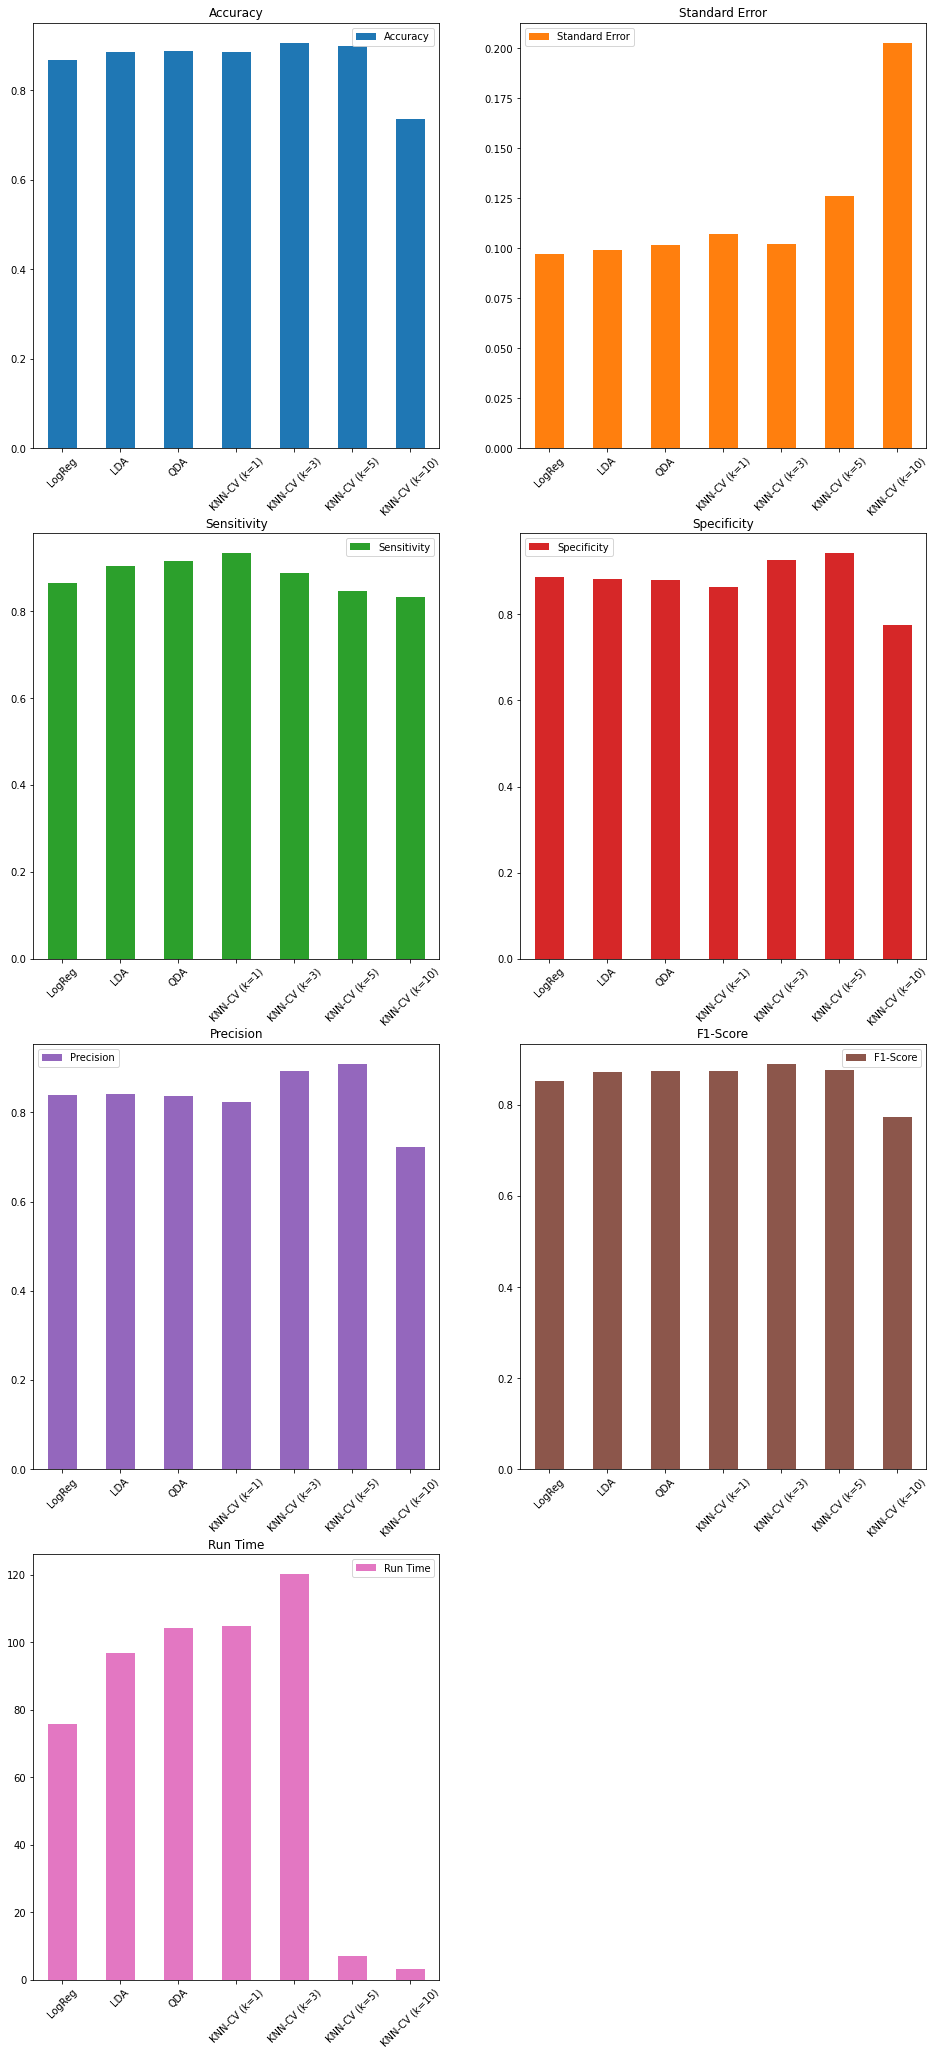

In [ ]:
transitionsdf.plot.bar(rot=45, subplots=True, figsize=(16,36), sharex=False, layout=(4, 2))